This is the first project of the Greedy-tech NLP Camp. Our goal is to understand each part of the NLP task and build a retrieval-based QA system.
The organization of this project is as follows:
Part 1: build a word segmentation tool with the enumeration method
part 2: apply the Viterbi algorithm to decrease the time complexity
part 3: understand the dataset, which involves the question-answer pair
part 4: text preprocessing
part 5: word representation with tf-idf method
part 6: find the top 5 answers to a testing question by comparing the testing question's cosine similarity with the questions in the data set
part 7: apply the inverted index to decrease the time complexity
part 8: replace the tf-idf word representation with the word2vec method


part 1: build a word segmentation tool with the enumeration method 
The given data includes:
1) one Chinese dictionary, dic.xlsx
2) part of the words' probability. For other words' probability, if the word exists in the dictionary, then the probability is 0.00001, otherwise 0.

In [1]:
# use set to store the dictionary and check the given probability
import pandas as pd
dic_words = pd.read_excel('data\dic.xlsx',header=None)   # 保存词典库中读取的单词
dic_set = set(dic_words[0])
print('羊肚子' in dic_set)

word_prob = {"北京":0.03,"的":0.08,"天":0.005,"气":0.005,"天气":0.06,"真":0.04,"好":0.05,"真好":0.04,"啊":0.01,"真好啊":0.02, 
             "今":0.01,"今天":0.07,"课程":0.06,"内容":0.06,"有":0.05,"很":0.03,"很有":0.04,"意思":0.06,"有意思":0.005,"课":0.01,
             "程":0.005,"经常":0.08,"意见":0.08,"意":0.01,"见":0.005,"有意见":0.02,"分歧":0.04,"分":0.02, "歧":0.005}

print (sum(word_prob.values()))

True
1.0000000000000002


In [4]:
# build a naive word segmentation tool and check the results
import math
def word_segment_naive(input_str):
    segments = []
    best_score = 1e10       
    if(len(input_str) == 0):
        return segments
    for i in range(1,len(input_str)+1):
        word = input_str[0:i]
        if word in dic_set:
            subString = word_segment_naive(input_str[i:])
            if(len(subString)==0):
                segments.append([word])
            else:

                for st in subString:  
                    st = [word] + st
                    segments.append(st)
    for st in segments:
        score = 0
        for each in st:
            score -= math.log(word_prob.get(each,0.00001))
        if score < best_score:
            best_score = score
            best_segment = st  

    return [best_segment]

In [5]:
#test
print(word_segment_naive("今天天气好"))
print(word_segment_naive("今天的课程内容很有意思"))
print(word_segment_naive("经常有意见分歧"))

[['今天', '天气', '好']]
[['今天', '的', '课程', '内容', '很', '有意思']]
[['经常', '有', '意见', '分歧']]


time complexity: O(n^n), space complexity: O(n^n)

part 2: apply the Viterbi algorithm to decrease the time complexity

In [11]:
import numpy as np
def word_segment_viterbi(input_str):
    # use a matrix to store the pre-calculated probability
    node_num = len(input_str) + 1
    graph = np.zeros((node_num, node_num), dtype=int)
    for i in range(node_num):
        for j in range(i, node_num):
            if i != j:
                if word_prob.get(input_str[i:j]) is None:
                    if j-i == 1:
                        ratio = -math.log(0.00001)
                    else:
                        ratio = 0
                else:
                    ratio = -math.log(word_prob.get(input_str[i:j]))
                graph[i][j] = ratio
                
    # use dp to solve the viterbi problem
    dp = [10000 for _ in range(node_num)]
    dp[0] = 0
    path = [0 for _ in range(node_num)]
    for i in range(1, node_num):
        for j in range(i):

            if graph[j][i] != 0:
                if dp[j] + graph[j][i] < dp[i]:

                    dp[i] = dp[j] + graph[j][i]
                    path[i] = j

    index = []
    last = len(path)-1
    while last != 0:
        index.append(path[last])
        last = path[last]

    index = index[::-1]
    best_segment = []
    for i in range(len(index)):
        if i == len(index) -1:
            best_segment.append(input_str[index[i]:])
        else:
            best_segment.append(input_str[index[i]:index[i+1]])
    return best_segment                 


In [12]:
#test
print(word_segment_viterbi("北京的天气真好啊"))
print(word_segment_viterbi("今天的课程内容很有意思"))
print(word_segment_viterbi("经常有意见分歧"))

['北京', '的', '天气', '真好啊']
['今天', '的', '课程', '内容', '很有', '意思']
['经常', '有意见', '分歧']


time complexity: O(n^3), space complexity: O(n^2)

Potential further improvement:
1) the current probability is calculated based on the collected documents. We can consider more data to get more accurate probability
2) one-order markov is nor precise
3) it can not deal with polysemy
4) if the words do not exist in the dictionary, these words can not be segmented correctly.

part 3:understand the dataset, which involves the question-answer pair
From this part, we start build our retrieval-based QA system.
The given data includes:
1) dev-v2.0.json file includes the question-answer pair

In [13]:
# read file and plot the data
import json
def read_corpus():
    with open('data/train-v2.0.json', encoding='utf-8') as fp:
        data = json.load(fp)
    qlist = []; alist = []
    for item in data["data"]:
        for para in item["paragraphs"]:
            for qa in para["qas"]:
                qlist.append(qa["question"])
                try:
                    alist.append(qa["answers"][0]["text"])
                except IndexError:
                    qlist.pop()
                
    assert len(qlist) == len(alist) 
    return qlist, alist
    

In [14]:
from collections import Counter
wordsCount = Counter()
qlist, alist = read_corpus()
for text in qlist:
    wordsCount.update(text.strip(' .!?').split(' '))
diff_word_total = len(wordsCount.keys())
word_total = sum(wordsCount.values())
print('diff_word_total:' , diff_word_total)
print('word_total:' , word_total)

diff_word_total: 51841
word_total: 874076


top 20 words
[['the', 60960], ['What', 36995], ['of', 33987], ['in', 21785], ['to', 18443], ['was', 17065], ['is', 16198], ['did', 15634], ['what', 13219], ['a', 10753], ['How', 8023], ['Who', 8009], ['and', 7229], ['for', 7200], ['many', 5497], ['are', 5455], ['When', 5367], ['that', 4436], ['were', 4428], ['does', 4331]]


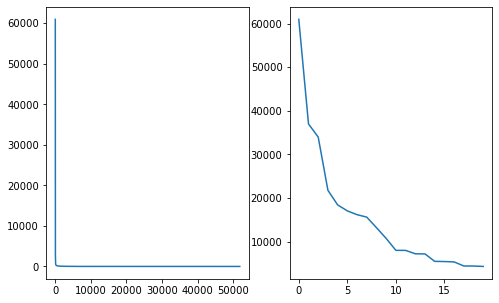

In [15]:
import matplotlib.pyplot as plt
valueSorted = sorted(wordsCount.values(),reverse=True)
plt.figure(figsize= [8, 5])
plt.subplot(1,2,1)
plt.plot(valueSorted)
plt.subplot(1,2,2)
plt.plot(valueSorted[0:20])
inverseDict = dict(zip(wordsCount.values(), wordsCount.keys()))
print("top 20 words")
print([[inverseDict[v],v] for v in valueSorted[:20]])

In [ ]:
# We can find the Zipf's law from the above figure.
# The figure is similar the exponential function. The frequency of the ranked first 
# word is two times of the frequency of the second one.

In [16]:
wordCountAns = Counter()
for text in alist:
    wordCountAns.update(text.strip(' .!?').split(' '))
valueSortedAns = sorted(wordCountAns.values(), reverse=True)
inverseDictrAns = dict(zip(wordCountAns.values(), wordCountAns.keys()))
print("top 20 words")
print([[inverseDictrAns[v],v] for v in valueSortedAns[0:20]])

top 20 words
[['the', 13211], ['of', 8893], ['and', 8172], ['to', 3440], ['a', 3294], ['in', 2838], ['The', 1769], ['or', 1261], ['for', 1032], ['million', 854], ['as', 840], ['by', 801], ['is', 722], ['on', 720], ['on', 720], ['from', 696], ['that', 664], ['an', 610], ['century', 556], ['their', 536]]


In [17]:
qlist[0:10]

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'When did Beyoncé rise to fame?',
 "What role did Beyoncé have in Destiny's Child?"]

In [18]:
alist[0:10]

['in the late 1990s',
 'singing and dancing',
 '2003',
 'Houston, Texas',
 'late 1990s',
 "Destiny's Child",
 'Dangerously in Love',
 'Mathew Knowles',
 'late 1990s',
 'lead singer']

part 4: text preprocessing

In [19]:
# stop words
#import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopSet = set(stopwords.words('english'))
stopSet.update({'-s','-ly','</s>','\'s','\'\'', '\''})

#stemmer
from nltk.stem import PorterStemmer
ps = PorterStemmer()

# tokenize
from nltk.tokenize import word_tokenize

import math
def textPreprocessing(text):
    seg = []
    for word in word_tokenize(text):
        word = ps.stem(word.lower())
        word = '#number' if word.isdigit() else word
        if len(word) > 1 and word not in stopSet:
            seg.append(word)
    return seg

wordsCount = Counter()
preQList = []
for text in qlist:
    seg = textPreprocessing(text)
    preQList.append(seg)
    wordsCount.update(seg)

valueSorted = sorted(wordsCount.values(), reverse=True)

# delete low frequency words
for cur in range(len(preQList)):
    preQList[cur] = [word for word in preQList[cur] if wordsCount[word] > 7]
    

In [20]:
valueSorted[int(0.20 * len(valueSorted))]
# In the above code, we use 7 as the frequency threshold, which represents 20% of the data.

7

In [21]:
preQList[:10]

[['beyonc', 'start', 'becom', 'popular'],
 ['area', 'beyonc', 'compet', 'wa', 'grow'],
 ['beyonc', 'leav', 'destini', 'child', 'becom', 'solo', 'singer'],
 ['citi', 'state', 'beyonc', 'grow'],
 ['decad', 'beyonc', 'becom', 'famou'],
 ['group', 'wa', 'lead', 'singer'],
 ['album', 'made', 'worldwid', 'known', 'artist'],
 ['manag', 'destini', 'child', 'group'],
 ['beyoncé', 'rise', 'fame'],
 ['role', 'beyoncé', 'destini', 'child']]

part 5: word representation with tf-idf method

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer =  TfidfVectorizer() 

X =  vectorizer.fit_transform([' '.join(seg) for seg in preQList])

In [23]:
sparsity =  X.nnz/float(X.shape[0] * X.shape[1]) * 100
print(str(sparsity) + '%') 

0.09614641890224648%


part 6: find the top 5 answers to a testing question by comparing the testing question's cosine similarity with the questions in the data set

In [24]:
import numpy as np
import scipy
from queue import PriorityQueue
def top5results(input_q):
    qVector = vectorizer.transform([' '.join(textPreprocessing(input_q))])
    pq = PriorityQueue()
    sim = (X * qVector.T).toarray()

    
    for i in range(X.shape[0]):
        pq.put((sim[i][0],i))
        if len(pq.queue) > 5:
            pq.get()
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x:x[0])
    
    top_idxs = [x[1] for x in pq_rank]  
                  

    return [alist[i] for i in top_idxs]  

In [25]:
# test
print(top5results("Which airport was shut down?")) 
print(top5results("Which airport is closed?"))

['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', '1991', '1985', 'aerodrome with facilities for flights to take off and land']
['Plymouth City Airport', 'aerodrome with facilities for flights to take off and land', 'May 12', 'After the reunification', 'related']


time complexity: O(ND)， space complexity: O(ND)
N refers to the number of questions in the data set
D refers to the size of the dictionary
We calculate the cosin-similarity with the D time complexity
Comparing the querried question with all N questions in data set is in time complexity N

part 7: apply the inverted index to decrease the time complexity

In [26]:
from collections import defaultdict
inverted_idx = defaultdict(set)
for cur in range(len(preQList)):
    for word in preQList[cur]:
        inverted_idx[word].add(cur)

In [28]:
inverted_idx['beyonc']

{0,
 1,
 2,
 3,
 4,
 15,
 16,
 17,
 18,
 19,
 21,
 30,
 31,
 32,
 33,
 34,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 52,
 53,
 54,
 55,
 56,
 58,
 63,
 66,
 67,
 68,
 69,
 70,
 78,
 79,
 83,
 89,
 91,
 92,
 93,
 94,
 101,
 110,
 111,
 112,
 113,
 115,
 117,
 125,
 126,
 128,
 130,
 131,
 141,
 149,
 153,
 154,
 160,
 161,
 163,
 164,
 166,
 167,
 173,
 175,
 176,
 177,
 179,
 180,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 209,
 214,
 215,
 216,
 217,
 225,
 226,
 227,
 228,
 229,
 230,
 233,
 238,
 240,
 241,
 242,
 244,
 251,
 252,
 253,
 255,
 265,
 266,
 276,
 277,
 278,
 279,
 281,
 283,
 289,
 290,
 292,
 293,
 299,
 300,
 301,
 302,
 303,
 304,
 305,
 306,
 309,
 314,
 315,
 316,
 317,
 323,
 324,
 325,
 326,
 327,
 329,
 330,
 336,
 337,
 350,
 360,
 361,
 362,
 370,
 371,
 372,
 379,
 381,
 383,
 391,
 392,
 395,
 396,
 397,
 398,
 399,
 400,
 403,
 408,
 409,
 410,
 411,
 412,
 413,
 414,
 420,
 421,
 422,
 423,
 424,
 425,
 433,

In [35]:
def top5results_invidx(input_q):
    preInputQ = textPreprocessing(input_q)
    candidate = set()
    for word in preInputQ:
        candidate = candidate | inverted_idx[word]
    candidate = list(candidate)
    
    qVector = vectorizer.transform([' '.join(preInputQ)])
    sim = (X[candidate] * qVector.T).toarray()
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0], candidate[cur]))
        if len(pq.queue) > 5:
            pq.get()
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x: x[0])
    top_idxs = [x[1] for x in pq_rank]
    return [alist[i] for i in top_idxs]    

In [36]:
# test
print(top5results_invidx("Which airport was shut down?"))    # 在问题库中存在，经过对比，返回的首结果正确
print(top5results_invidx("Which airport is closed?"))

['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', '1991', '1985', 'aerodrome with facilities for flights to take off and land']
['Plymouth City Airport', 'May 12', 'aerodrome with facilities for flights to take off and land', 'After the reunification', 'related']


time complexity: O(ND)， space complexity: O(ND)

part 8: replace the tf-idf word representation with the word2vec method

In the above part, we use the bag-of-words model. But this model can not consider the similarity between words and the representation vector is sparse. In the following part, we use the word2vec model with glove.6B.100.

In [37]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import numpy as np
_ = glove2word2vec('data/glove.6B.100d.txt','data/glove2word2vec.6B.100d.txt')
model = KeyedVectors.load_word2vec_format('data/glove2word2vec.6B.100d.txt')
def docvec_get(seg):
    # change the words in preQlist into vector
    vector = np.zeros([1,100])
    size = len(seg)
    for word in seg:
        try:
            vector += model.wv[word]
        except KeyError:
            size -= 1
    return vector / size
X = np.zeros([len(preQList), 100])
for cur in range(X.shape[0]):
    X[cur] = docvec_get(preQList[cur])
Xnorm2 = np.linalg.norm(X,axis=1,keepdims=True)
X/=Xnorm2

<ipython-input-37-29e519ee869c>:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vector += model.wv[word]
<ipython-input-37-29e519ee869c>:15: RuntimeWarning: invalid value encountered in true_divide
  return vector / size


In [38]:
def top5results_emb(input_q):
    seg = textPreprocessing(input_q)
    candidate = set()
    for word in seg:
        candidate = candidate | inverted_idx[word]
    candidate = list(candidate)
    qVector = docvec_get(seg)
    qnorm2 = np.linalg.norm(qVector,axis=1,keepdims=True)
    qVector/=qnorm2
   
    sim = (X[candidate] @ qVector.T)
  
    pq = PriorityQueue()
    for cur in range(sim.shape[0]):
        pq.put((sim[cur][0],candidate[cur]))
        if len(pq.queue) > 5:
            pq.get()
    pq_rank = sorted(pq.queue, reverse=True, key=lambda x: x[0])
    print([x[0] for x in pq_rank])
    top_idxs = [x[1] for x in pq_rank]
    return [alist[i] for i in top_idxs]


In [39]:
#test
print(top5results_emb("Which airport was shut down?"))
print(top5results_emb("Which airport is closed?"))

[1.0, 1.0, 0.8980219398331406, 0.8875869259222657, 0.8826214612899687]
['Chengdu Shuangliu International Airport', 'Chengdu Shuangliu International Airport', 'Impregilo', 'Terminal C', 'Nanjing Dajiaochang Airport']
[0.9454294862808651, 0.897533314447132, 0.8921468921909476, 0.8917413888585661, 0.8866939369431388]
['Plymouth City Airport', 'Norwood Memorial Airport', 'Beverly Municipal Airport', 'Dushanbe International Airport', 'Lukou International Airport']


<ipython-input-37-29e519ee869c>:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vector += model.wv[word]
